# 3. Linear Models for Classification

### *Table of Contents*
* 4.1 [Discriminant Functions](#4.1-Discriminant-Functions)
* 4.2 [Probabilistic Generative Models](#4.2-Probabilistic-Generative-Models)
* 4.3 [Probabilistic Discriminative Models](#4.3-Probabilistic-Discriminative-Models)
* 4.4 [Laplace Approximation](#4.4-Laplace-Approximation)
* 4.5 [Bayesian Logistic Regression](#4.5-Bayesian-Logistic-Regression)

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from prml.preprocessing import LinearFeature
from prml.linear import LeastSquaresClassifier

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide = 'ignore', invalid='ignore')

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

The goal in classification is to take an input vector $\mathbf{x}$ and assign it to one of $K$ discrete classes $\mathcal{C}_k$, where $k=1\dots,K$. The input space is thereby divided into *decision regions* whose boundaries are called *decision boundaries* or *decision surfaces*. Linear models define decision surfaces as linear functions of the input vector $\mathbf{x}$ and hence are defined by $(D-1)$-dimensional hyperplanes inside the $D$-dimensional space. Datasets whose classes can be separated exactly by linear decision surfaces are called *linearly separable*.

There are three distinct approaches to the classification problem:

1. Discriminant functions that directly assign each input vector $\mathbf{x}$ to a class.
2. Models that directly learn the conditional probability $p(\mathcal{C}_k|\mathbf{x})$ using parametric modelling.
3. Generative approaches that model the class conditional density $p(\mathbf{x}|\mathcal{C}_k)$, and the prior probabilities $p(\mathcal{C}_k)$ for the classes. Then they derive the posterior using the Bayes theorem.

In the linear regression models, the model prediction $y(\mathbf{x}, \mathbf{w})$ was given by a linear function of the parameters $\mathbf{w}$. For classification problems, however, we wish to predict discrete class labels. To that end, we consider a generalization of the above model in which we transform the linear function using a nonlinear function $f(\cdot)$ so that

$$
y(\mathbf{x}) = f(\mathbf{w}^T\mathbf{x} + w_0)
$$

In machine learning, the function $f$ is known as an *activation function*.

## 4.1 Discriminant Functions

A discriminant is a function that assigns one of $K$ classes to an input vector $\mathbf{x}$. *Linear discriminants* define decision surfaces that are hyperplanes.


### 4.1.1 Two Classes

The simplest linear discriminant function is obtained by taking a linear function of the input vector so that,

$$
y(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + w_0
$$

where $\mathbf{w}$ is a *weight vector* and $w_0$ is a *bias* (the negative of the bias is also called *threshold*). Then, an input $\mathbf{x}$ is assigned to a class $\mathcal{C}_1$ if $y(\mathbf{x})\geq0$ and to class $\mathcal{C}_2$ otherwise. Thus, the decision boundary is defined by $y(\mathbf{x})=0$.

Consider two points $\mathbf{x}_A$ and $\mathbf{x}_B$ onto the decision surface. Then, $y(\mathbf{x}_A)=y(\mathbf{x}_B)=0 \Leftrightarrow \mathbf{w}^T(\mathbf{x}_A-\mathbf{x}_B)=0$, which implies that the vector $\mathbf{w}$ is orthogonal to every vector lying in the decision surface as depicted below:

<img src="../images/fg4_1.png" width="400"/>

Note that for more than two classes ($K>2$), a *one-vs-the-rest* classifier can be used in order to avoid regions of input space that are ambiguously classified. The linear function of each class takes the form $y_k(\mathbf{x}) = \mathbf{w}_k^T\mathbf{x} + w_{k0}$, and assigns a point $\mathbf{x}$ to class $\mathcal{C}_k$ if $y_k(\mathbf{x}) > y_j(\mathbf{x}) \; \forall j\neq k$.

In the following sections we explore three approaches to learning the parameters of linear discriminant functions:

1. Least squares
2. Fisher's linear discriminant
3. Perceptron algorithm

### 4.1.3 Least squares for classification

In [Chapter 3](ch3_linear_models_for_regression.ipynb), we minimized the sum-of-squared error function led to a closed-form solution for the parameter values. Can we apply the same principle to classification problems?

Consider a general classification problem having $K$ classes. Using a $1$-of-$K$ binary coding scheme or *one-hot* encoding for the target vector.

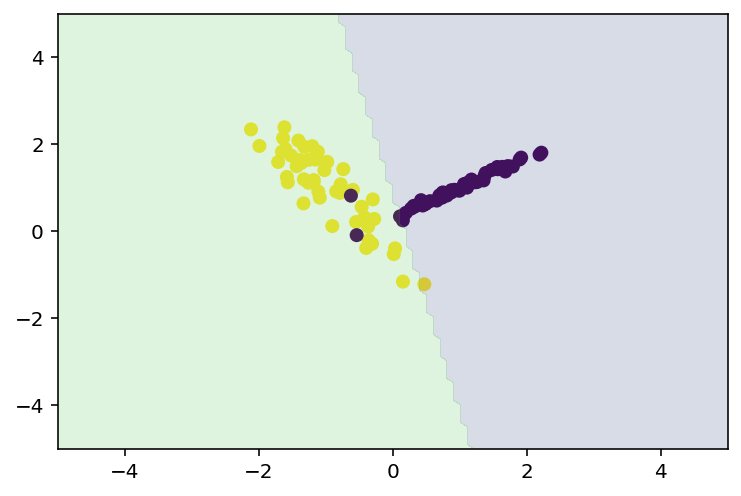

In [29]:
# number of training points
N = 100

x_train, t = make_classification(
    n_features=2, 
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    n_samples=N
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

feature = LinearFeature()
x_train_linear = feature.transform(x_train)
x_test_linear = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(x_train_linear, t)
predicted = model.predict(x_test_linear)

plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.show()

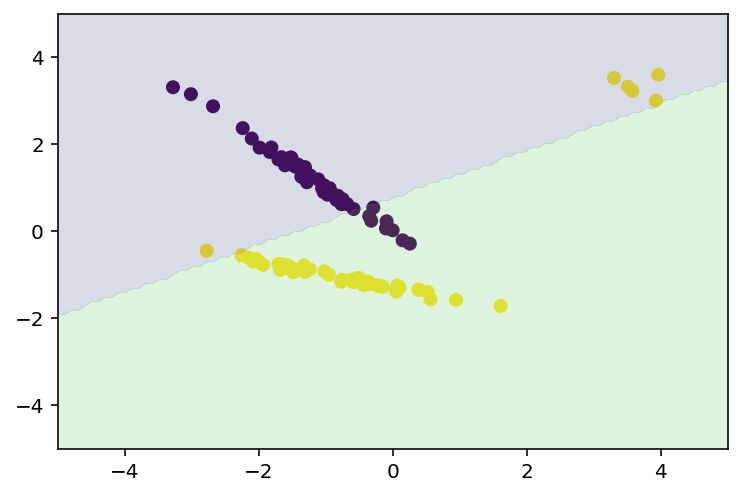

In [86]:
# number of training points
N = 100
n_outliers = 5

x_train, t = make_classification(
    n_features=2, 
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    n_samples=N
)

outliers = np.random.random_sample((n_outliers, 2)) + 3
x_train = np.vstack((x_train, outliers))
t = np.hstack((t, np.ones(n_outliers, dtype=int)))

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

feature = LinearFeature()
x_train_linear = feature.transform(x_train)
x_test_linear = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(x_train_linear, t)
predicted = model.predict(x_test_linear)

plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.show()

### 4.1.4 Fisher's linear discriminant

### 4.1.7 The perceptron algorithm